In [20]:
# Import the fucking useful libraries =)
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt
import random
from IPython import display
from helpers import *
from sklearn.linear_model import Ridge

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# There's a lot of columns in the DF. 
# Therefore, we add this option so that we can see more columns
pd.options.display.max_columns = 100

In [21]:
# Define here the data set
dataset = '../data/data_train.csv'

In [22]:
data = prepare_data(dataset)
data = data.drop('Id', axis=1)

Load the dataset


In [23]:
data.head()


,Prediction,UserID,MovieID
0,4,43,0
1,3,60,0
2,4,66,0
3,3,71,0
4,5,85,0


In [24]:
# Shuffle the data
rowID = np.array(data.index)
np.random.shuffle(rowID)
shuffled = data.ix[rowID].sort('UserID').set_index('UserID')

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [25]:
## Split the train and test set for each user
def split(user):
    df = shuffled.ix[user]
    N = len(df)
    Ntest = int(N/3)
    Ntrain = N - Ntest
    train = df.head(Ntrain)
    test = df.tail(Ntest)
    return train, test

In [26]:
## Create the train and test sets for all users
for user in shuffled.index.unique():
    if user == 0:
        train, test = split(user)
    else:
        a, b = split(user)
        train = train.append(a)
        test = test.append(b)
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [27]:
rating_train = train.pivot(index='UserID', columns='MovieID').Prediction
rating_test = test.pivot(index='UserID', columns='MovieID').Prediction
userID, movieID = rating_train.index, rating_train.columns
Nu, Nm = len(userID), len(movieID)

print('training matrix =', rating_train.shape)
print('test matrix =', rating_test.shape)

training matrix = (10000, 1000)
test matrix = (10000, 1000)


In [67]:
## number of movie features
n = 20

## Matrix of user preferences
U = pd.DataFrame(np.random.rand(Nu, n), index=userID, columns=range(1, n+1))

## Matrix of movie features
M = pd.DataFrame(np.random.rand(Nm, n), index=movieID, columns=range(1, n+1))

U0, M0 = U.copy(), M.copy()
print(U.shape, M.shape)

(10000, 20) (1000, 20)


In [58]:
def CVerror(alpha):
    bestFit = {'U': U0, 'M': M0, 'error': np.inf}
    fitUM(bestFit, alpha)
    U_opt, M_opt, train_error = bestFit['U'], bestFit['M'], bestFit['error']
    pred = predict(U_opt, M_opt)
    train_error = rmse(rating_train, pred)
    CV_error = rmse(rating_test, pred)
    return train_error, CV_error

In [59]:
def rmse(y, yhat):
    err = (y - yhat) ** 2
    return np.sqrt(np.mean(err.mean(skipna=True)))

In [73]:
## Fit the user preferences (U)
def fitU(error_history, bestFit, alpha=1):  
    ## Join ratings and movie features
    Udata = train.set_index('MovieID').join(M).sort('UserID').set_index('UserID')
    ## Function for fitting individual users
    model = Ridge(fit_intercept=False, alpha=alpha)
    def Ufit(i):
        df = Udata.ix[i]
        print(df)
        asd
        X = df.drop('Prediction', axis=1)
        y = df.Prediction
        model.fit(X, y)
        return model.coef_
    ## Fit all users
    for i in userID:
        U.ix[i] = Ufit(i)
    ## Calculate the error
    pred = predict(U, M)
    error = rmse(rating_train, pred)
    error_history.append(error)
    delta = bestFit['error'] - error
    if delta > 0:
        bestFit['U'] = U
        bestFit['M'] = M
        bestFit['error'] = error
    return delta

## Fit the movie features (M)
def fitM(error_history, bestFit, alpha=1):
    ## Join ratings and user preferences
    Mdata = train.set_index('UserID').join(U).sort('MovieID').set_index('MovieID')
    ## Function for fitting individual movies
    model = Ridge(fit_intercept=False, alpha=alpha)
    def Mfit(j):
        df = Mdata.ix[j]
        X = df.drop('Prediction', axis=1)
        y = df.Prediction
        model.fit(X, y)
        return model.coef_
    ## Fit all movies 
    for j in movieID:
        M.ix[j] = Mfit(j)
    ## Calculate the error
    pred = predict(U, M)
    error = rmse(rating_train, pred)
    error_history.append(error)
    delta = bestFit['error'] - error
    if delta > 0:
        bestFit['U'] = U
        bestFit['M'] = M
        bestFit['error'] = error
    return delta

## Predict the ratings (U dot M)
def predict(U, M):
    pred = U.dot(M.T)
    pred[pred > 5] = 5
    pred[pred < 1] = 1
    return pred

## Repeat the optimization until convergence
def fitUM(bestFit, alpha=1, tol=0.05):
    U, M = U0.copy(), M0.copy()
    error_history = []
    delta = fitU(error_history, bestFit, alpha=alpha)
    tolerance = tol
    while delta > tolerance:
        delta = fitM(error_history, bestFit, alpha=alpha)
        if delta > tolerance:
            delta = fitU(error_history, bestFit, alpha=alpha)
    return error_history

In [61]:
alphas = range(10,30)

In [62]:
train_errors, CV_errors = [], []
for alpha in alphas:
    print("Start for alpha =", alpha)
    err1, err2 = CVerror(alpha)
    train_errors.append(err1)
    CV_errors.append(err2)

Start for alpha = 10


/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:30: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Start for alpha = 11
Start for alpha = 12
Start for alpha = 13
Start for alpha = 14
Start for alpha = 15
Start for alpha = 16
Start for alpha = 17
Start for alpha = 18
Start for alpha = 19
Start for alpha = 20
Start for alpha = 21
Start for alpha = 22
Start for alpha = 23
Start for alpha = 24
Start for alpha = 25
Start for alpha = 26
Start for alpha = 27
Start for alpha = 28
Start for alpha = 29


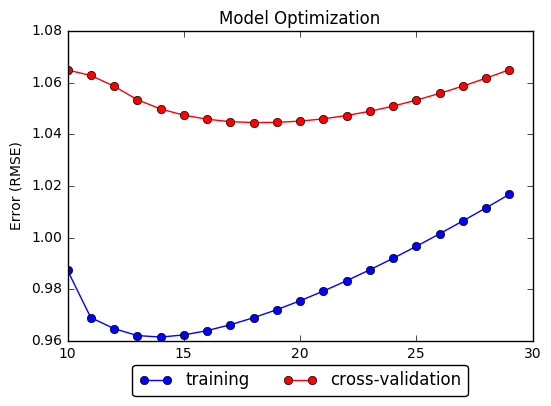

In [63]:
ax = plt.gca()
plt.plot(alphas, train_errors, '-o', label='training')
plt.plot(alphas, CV_errors, '-o', color='r', label='cross-validation')
plt.xlabel('Regularization Parameter')
plt.ylabel('Error (RMSE)')
plt.title('Model Optimization')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=2)
plt.show()

In [64]:
np.min(CV_errors)

1.044487330406223

In [68]:
alpha = alphas[np.argmin(CV_errors)]
alpha = 19


In [74]:
U = pd.DataFrame(np.random.rand(Nu, n), index=userID, columns=range(1, n+1))
M = pd.DataFrame(np.random.rand(Nm, n), index=movieID, columns=range(1, n+1))
U0, M0 = U.copy(), M.copy()
error_history = []
bestFit = {'U': U0, 'M': M0, 'error': np.inf}
fitUM(bestFit, alpha)
U_opt, M_opt, error = bestFit['U'], bestFit['M'], bestFit['error']
pred = predict(U_opt, M_opt)
print('Model RMSE =', error)

        Prediction         1         2         3         4         5  \
UserID                                                                 
0                5  0.810392  0.521788  0.226250  0.274181  0.982686   
0                5  0.450515  0.358695  0.875065  0.169919  0.262437   
0                4  0.746447  0.279331  0.920004  0.686461  0.438469   
0                3  0.627732  0.302029  0.778721  0.603090  0.554393   
0                2  0.737246  0.031578  0.503159  0.154567  0.178410   
0                5  0.542773  0.126423  0.019278  0.599662  0.873723   
0                5  0.635283  0.240513  0.377407  0.710253  0.772004   
0                5  0.654664  0.490617  0.475063  0.999256  0.451453   
0                5  0.501132  0.843814  0.728559  0.961268  0.331791   
0                4  0.534674  0.342458  0.047638  0.265266  0.048836   
0                5  0.412647  0.880310  0.842058  0.943482  0.995730   
0                2  0.762302  0.765538  0.837038  0.375476  0.94

/home/gael/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


NameError: name 'asd' is not defined

In [160]:
def jitter(y, yhat, title=''):
    pred = np.round(yhat)
    pred[pred > 5] = 5
    pred[pred < 1] = 1
    def noise():
        return np.random.randn(len(y)) * 0.1
    y_jitter = y + noise() 
    yhat_jitter = pred + noise() 
    plt.scatter(y_jitter, yhat_jitter)
    plt.xlabel('Actual Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.axis('image')
    plt.grid()
    plt.show()

In [41]:
mat = U_opt.dot(M_opt.T)
mat.shape

(10000, 1000)

# Testing

In [38]:
# Test data
dataset_test = '../data/sampleSubmission.csv'
data_test = prepare_data(dataset_test)

Load the dataset


In [39]:
data_test.head()

,Id,Prediction,UserID,MovieID
0,r37_c1,3,36,0
1,r73_c1,3,72,0
2,r156_c1,3,155,0
3,r160_c1,3,159,0
4,r248_c1,3,247,0


In [42]:
predictions = []
for i in range(len(data_test)):
    dd = data_test.iloc[i]
    predictions.append(mat[dd.MovieID][dd.UserID])
    if (i+1)%10000 == 0:
        print("%i/%i done!"%(i+1, len(data_test)))

10000/1176952 done!
20000/1176952 done!
30000/1176952 done!
40000/1176952 done!
50000/1176952 done!
60000/1176952 done!
70000/1176952 done!
80000/1176952 done!
90000/1176952 done!
100000/1176952 done!
110000/1176952 done!
120000/1176952 done!
130000/1176952 done!
140000/1176952 done!
150000/1176952 done!
160000/1176952 done!
170000/1176952 done!
180000/1176952 done!
190000/1176952 done!
200000/1176952 done!
210000/1176952 done!
220000/1176952 done!
230000/1176952 done!
240000/1176952 done!
250000/1176952 done!
260000/1176952 done!
270000/1176952 done!
280000/1176952 done!
290000/1176952 done!
300000/1176952 done!
310000/1176952 done!
320000/1176952 done!
330000/1176952 done!
340000/1176952 done!
350000/1176952 done!
360000/1176952 done!
370000/1176952 done!
380000/1176952 done!
390000/1176952 done!
400000/1176952 done!
410000/1176952 done!
420000/1176952 done!
430000/1176952 done!
440000/1176952 done!
450000/1176952 done!
460000/1176952 done!
470000/1176952 done!
480000/1176952 done!
4

In [43]:
for i in range(len(predictions)):
    if predictions[i] > 5:
        predictions[i] = 5
    elif predictions[i] < 1:
        predictions[i] = 1

In [44]:
data_test['Prediction'] = predictions
data_test.head()

,Id,Prediction,UserID,MovieID
0,r37_c1,3.160444,36,0
1,r73_c1,2.830633,72,0
2,r156_c1,3.454183,155,0
3,r160_c1,3.186285,159,0
4,r248_c1,3.098738,247,0


In [45]:
data_test = data_test.drop(['UserID', 'MovieID'], axis=1)

In [46]:
data_test.to_csv('collaborative_filtering.csv', index=False)

In [47]:
data_test.head()

,Id,Prediction
0,r37_c1,3.160444
1,r73_c1,2.830633
2,r156_c1,3.454183
3,r160_c1,3.186285
4,r248_c1,3.098738
